# Transfer Learning

En este caso vamos a hacer Transfer Learning sobre una ResNet18 utilizando el dataset CIFAR10. Este cuenta con imagenes RGB de 32x32 pixeles divididas en 10 clases. Dichas imagenes tienen una resolucion bastante menor a la utilizada para preentrenar el modelo ResNet18, el cual se entreno con ImageNet (224x224).De esta forma, se podra observar los efectos de los cambios de tamaño en las imagenes y como estos repercuten en la performance de la red.

In [1]:
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

### CIFAR10

Se puede descargar y descomprimir el dataset CIFAR10 con la siguiente celda

In [3]:
!gdown 1r-EHlcCbEOXW9x3no0JjM6PSYfVMvZST
!unzip cifar10.zip > /dev/null

Downloading...
From (uriginal): https://drive.google.com/uc?id=1r-EHlcCbEOXW9x3no0JjM6PSYfVMvZST
From (redirected): https://drive.google.com/uc?id=1r-EHlcCbEOXW9x3no0JjM6PSYfVMvZST&confirm=t&uuid=9c1b3a57-2453-4ddb-af81-e1b50e36cac9
To: /content/cifar10.zip
100% 149M/149M [00:04<00:00, 34.6MB/s]


### Visualización de los datos

In [4]:
CANTIDAD_CLASES = 10
ANCHO_IMAGENES = 32
ALTO_IMAGENES = 32

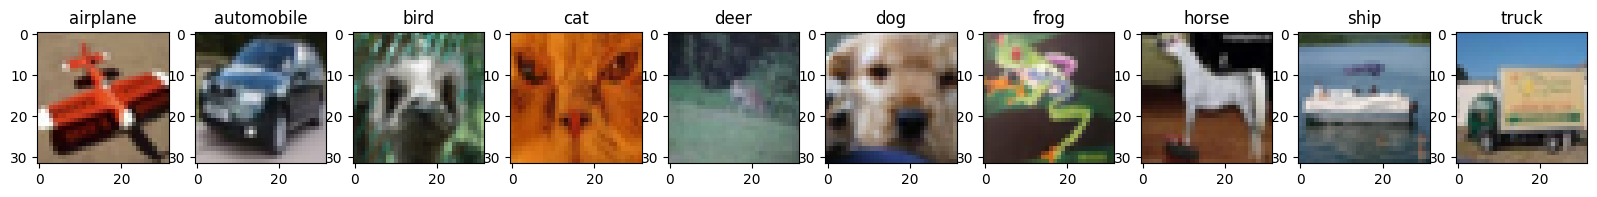

In [5]:
train_folder = './cifar10/train/'

fig, axs = plt.subplots(1, 10, figsize=(20, 20))

for id, class_folder in enumerate(sorted(os.listdir(train_folder))):

    image_name = random.choice(os.listdir(os.path.join(train_folder, class_folder)))
    image = mpimg.imread(os.path.join(train_folder, class_folder, image_name))

    axs[id].imshow(image)
    axs[id].set_title(class_folder)

### Definimos nuestra función de entrenamiento

In [6]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

### Descargo modelo ResNet 18 desde torchvision

El modelo [resnet18](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) provisto por torchvision cuenta con un set de parametros preentrenados con ImageNet, los cuales consiguen metricas similares a las del paper original. Dada la arquitectura del modelo, la cual cuenta con una capa de [Adaptative Average Pooling](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html?highlight=adaptiveavgpool2d#torch.nn.AdaptiveAvgPool2d) y solo una capa densa al final, puede tomar entradas de dimensiones muy pequeñas.

In [7]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [8]:
resnet18_model = resnet18(weights=weights)

if torch.cuda.is_available():
    resnet18_model.to("cuda")

torchsummary.summary(resnet18_model, input_size=(3, 32, 32))
resnet18_model.modules

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [9]:
for param in resnet18_model.parameters():
    param.requires_grad = False

last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

Utilizamos el pipeline de transformacion predefinidos dentro de torchvision para el dataset CIFAR10. De esta forma las imagenes mantienen su tamaño de 32x32 pixeles.

In [10]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()
                  ])

cifar10_train_set = torchvision.datasets.ImageFolder(root='./cifar10/train', transform=transforms)
cifar10_test_set = torchvision.datasets.ImageFolder(root='./cifar10/test', transform=transforms)

cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_set, batch_size=32, shuffle=True)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_set, batch_size=32, shuffle=True)

Epoch: 1/10 - Train loss 2.178502 - Train Accuracy 0.219470 - Valid Loss 1.994701 - Valid Accuracy 0.341454
Epoch: 2/10 - Train loss 1.865416 - Train Accuracy 0.425244 - Valid Loss 1.724145 - Valid Accuracy 0.503295
Epoch: 3/10 - Train loss 1.640773 - Train Accuracy 0.538868 - Valid Loss 1.532122 - Valid Accuracy 0.578874
Epoch: 4/10 - Train loss 1.476247 - Train Accuracy 0.600328 - Valid Loss 1.385144 - Valid Accuracy 0.626298
Epoch: 5/10 - Train loss 1.354843 - Train Accuracy 0.632418 - Valid Loss 1.274168 - Valid Accuracy 0.651757
Epoch: 6/10 - Train loss 1.260485 - Train Accuracy 0.656670 - Valid Loss 1.188879 - Valid Accuracy 0.668231
Epoch: 7/10 - Train loss 1.189698 - Train Accuracy 0.668326 - Valid Loss 1.129711 - Valid Accuracy 0.682009
Epoch: 8/10 - Train loss 1.130340 - Train Accuracy 0.681542 - Valid Loss 1.068716 - Valid Accuracy 0.694089
Epoch: 9/10 - Train loss 1.083810 - Train Accuracy 0.688780 - Valid Loss 1.025560 - Valid Accuracy 0.704373
Epoch: 10/10 - Train loss 1.

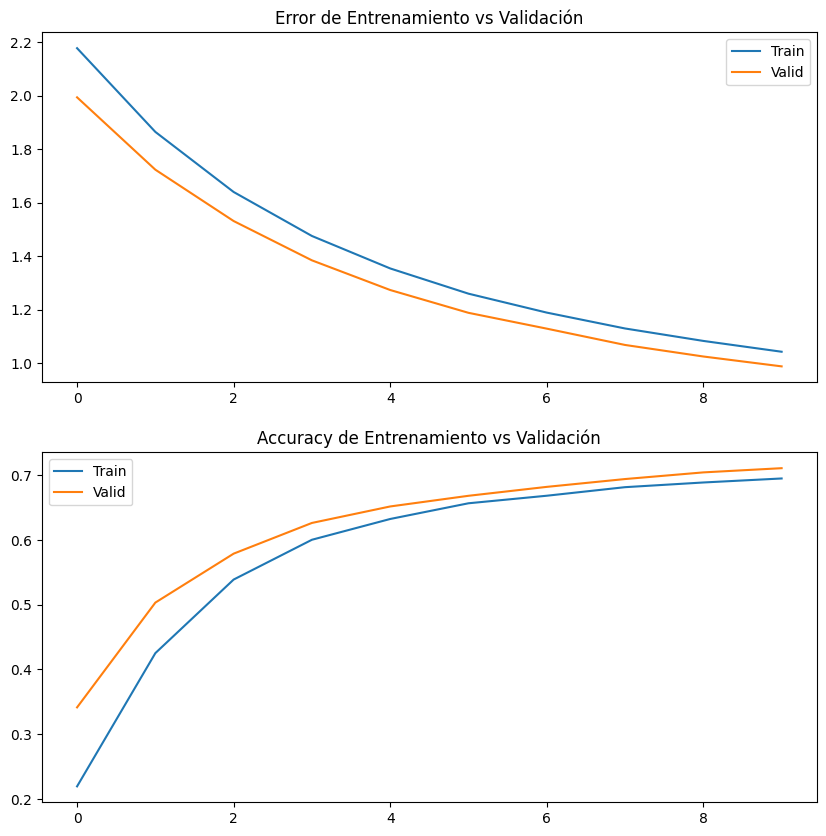

In [11]:
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.00001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": cifar10_train_loader, "valid": cifar10_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning/train"),
          "valid": SummaryWriter(log_dir="transfer_learning/valid")}

history = train(resnet18_model.to("cpu"), 
                optimizer, 
                loss, 
                metric,
                data,
                10,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])